# Direct sampling with Gaussian process regression

#### Import general modules

mpi4py is always required when using these tools. Numpy is always good to have if any manipulation is to be done.

In [13]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

#### Import modules from pynektools

In this case we will import all the data types that we currently support, as well as io functions that are required to populate them.

In [14]:
# Data types
from pynektools.datatypes.msh import Mesh
from pynektools.datatypes.coef import Coef
from pynektools.datatypes.field import Field, FieldRegistry

# Readers
from pynektools.io.ppymech.neksuite import preadnek, pynekread

# Writers
from pynektools.io.ppymech.neksuite import pwritenek, pynekwrite

fname = '/home/adperez/cpc_gaussian_process_compression/data/mixlay/mixlay0.f00001'
#fname = '/home/adperez/Documents/gaussian_process/Gaussian Process_0823/data/turbPipe/turbPipe0.f00001'


## Read the data

In [15]:
msh = Mesh(comm, create_connectivity=False)
fld = FieldRegistry(comm)

pynekread(fname, comm, data_dtype=np.double, msh = msh, fld = fld)


for e in range(msh.nelv):
    if (np.min(msh.x[e]), np.max(msh.x[e])) == (0, 0.25):
        if (np.min(msh.y[e]), np.max(msh.y[e])) == (0, 1.1399999856948853):
            print(e)
    
coef = Coef(msh=msh, comm=comm)

2025-02-20 14:39:59,200 - Mesh - INFO - Initializing empty Mesh object.
2025-02-20 14:39:59,202 - Field - INFO - Initializing empty Field object
2025-02-20 14:39:59,203 - pynekread - INFO - Reading file: /home/adperez/cpc_gaussian_process_compression/data/mixlay/mixlay0.f00001
2025-02-20 14:39:59,206 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-02-20 14:39:59,207 - Mesh - INFO - Initializing common attributes.
2025-02-20 14:39:59,207 - Mesh - INFO - Getting vertices
2025-02-20 14:39:59,209 - Mesh - INFO - Getting edge centers
2025-02-20 14:39:59,216 - Mesh - INFO - Facet centers not available for 2D
2025-02-20 14:39:59,217 - Mesh - INFO - Mesh object initialized.
2025-02-20 14:39:59,218 - Mesh - INFO - Mesh data is of type: float64
2025-02-20 14:39:59,218 - Mesh - INFO - Elapsed time: 0.011908888000000672s
2025-02-20 14:39:59,219 - pynekread - INFO - Reading field data
2025-02-20 14:39:59,222 - pynekread - INFO - File read
2025-02-20 14:39:59,223 - pynekread - INF

## Initialize the Direct sampler

In [16]:
from pynektools.compression.gpc_direct_sampling import DirectSampler

ds = DirectSampler(comm=comm, msh=msh, coef=coef)

In [ ]:
#ds.estimate_covariance("average", elements_to_average=100)
#ds.sample(method="fixed_bitrate", n_samples=63)

ds.log.tic()
n_samples = 8
bitrate = n_samples/(msh.lx*msh.ly*msh.lz)
#ds.sample_field(field=fld.registry["u"], field_name="u", covariance_method="svd", compression_method="fixed_bitrate", bitrate = bitrate, covariance_keep_modes=1)
#ds.sample_field(field=fld.registry["u"], field_name="u", covariance_method="average", covariance_elements_to_average=int(msh.nelv/16), compression_method="fixed_bitrate", bitrate = bitrate)
ds.sample_field(field=fld.registry["u"], field_name="u", covariance_method="average", covariance_elements_to_average=msh.nelv, compression_method="fixed_bitrate", bitrate = bitrate)
ds.log.toc()

2025-02-20 14:39:59,325 - DirectSampler - INFO - Sampling the field with options: covariance_method: {covariance_method}, compression_method: {compression_method}
2025-02-20 14:39:59,326 - DirectSampler - INFO - Estimating the covariance matrix
2025-02-20 14:39:59,326 - DirectSampler - INFO - Transforming the field into to legendre space
2025-02-20 14:39:59,335 - DirectSampler - INFO - Estimating the covariance matrix using the averaging method method. Averaging over 1 elements at a time
2025-02-20 14:39:59,363 - DirectSampler - INFO - Covariance saved in field data_to_compress["u"]["kw"]
2025-02-20 14:39:59,364 - DirectSampler - INFO - Sampling the field using the fixed bitrate method. using settings: {'method': 'fixed_bitrate', 'bitrate': np.float64(0.125), 'n_samples': 8}


[0]
Proccesing up to 1600/1600 elements
0.0
start:procedures
(1600, 1, 1, 64)
(1, 1, 64, 64)
(1600, 1, 64, 64)
(1600, 1, 1, 64)
(1600, 1, 1, 1)
(1600, 1, 1, 64)
(1600, 1, 1, 64)
(1600, 1, 64, 1)
(1600, 1, 64, 64)
(1600, 1, 64, 64)
(1600, 1, 64, 64)
(1600, 1, 64)
procedure ends
0.125
start:procedures
(1600, 1, 2, 64)
(1, 1, 64, 64)
(1600, 1, 64, 64)
(1600, 1, 2, 64)
(1600, 1, 2, 2)
(1600, 1, 2, 64)
(1600, 1, 2, 64)
(1600, 1, 64, 2)
(1600, 1, 64, 64)
(1600, 1, 64, 64)
(1600, 1, 64, 64)
(1600, 1, 64)
procedure ends
0.25
start:procedures
(1600, 1, 3, 64)
(1, 1, 64, 64)
(1600, 1, 64, 64)
(1600, 1, 3, 64)
(1600, 1, 3, 3)
(1600, 1, 3, 64)
(1600, 1, 3, 64)
(1600, 1, 64, 3)
(1600, 1, 64, 64)
(1600, 1, 64, 64)
(1600, 1, 64, 64)
(1600, 1, 64)
procedure ends
0.375
start:procedures
(1600, 1, 4, 64)
(1, 1, 64, 64)
(1600, 1, 64, 64)
(1600, 1, 4, 64)
(1600, 1, 4, 4)
(1600, 1, 4, 64)
(1600, 1, 4, 64)
(1600, 1, 64, 4)
(1600, 1, 64, 64)
(1600, 1, 64, 64)
(1600, 1, 64, 64)
(1600, 1, 64)
procedure ends
0.5

In [18]:
# Hack it a bit to make the rest work

ds.field = fld.registry["u"]
ds.field_sampled = ds.data_to_compress["u"]["field"]
ds.kw = ds.data_to_compress["u"]["kw"]

print(ds.kw.shape)

ds.elements_to_average = ds.settings["covariance"]["elements_to_average"]
ds.n_samples = ds.settings["compression"]["n_samples"]

(1600, 64)


In [19]:
ind_50 = np.where(ds.field_sampled[0] == -50)
#print(ds.field[0])
#print(ds.field_sampled[0])
a = abs(ds.field_sampled[0])-abs(ds.field[0])
a[ind_50] = -50
print(a)

[[[  0. -50. -50. -50. -50. -50. -50.   0.]
  [-50. -50. -50. -50. -50. -50. -50. -50.]
  [-50. -50. -50. -50. -50. -50. -50. -50.]
  [-50. -50. -50.   0. -50. -50. -50. -50.]
  [-50. -50. -50. -50.   0.   0. -50. -50.]
  [-50. -50. -50. -50. -50. -50. -50. -50.]
  [-50. -50. -50. -50. -50. -50. -50. -50.]
  [  0. -50. -50. -50.   0. -50. -50.   0.]]]


In [20]:

print(ds.field_hat[1466].reshape(-1,1, order='F'))

print("======")

print(ds.field_sampled[1466].reshape(-1,1, order='F'))

[[ 1.99990441e-01]
 [-5.57531503e-06]
 [-1.80462288e-08]
 [ 7.00211732e-09]
 [-9.51879178e-09]
 [ 2.13566155e-09]
 [-5.95115817e-10]
 [-5.36121616e-10]
 [-8.59488645e-06]
 [-5.00078505e-06]
 [-3.83074439e-09]
 [ 8.52690949e-09]
 [-8.40598942e-09]
 [ 2.39046847e-09]
 [-8.58811016e-10]
 [-2.42388614e-10]
 [-2.37776126e-06]
 [-1.36844321e-06]
 [ 1.57842481e-08]
 [ 5.69112633e-09]
 [-2.72724125e-09]
 [ 4.27633113e-10]
 [-4.92429909e-10]
 [ 4.96550225e-10]
 [ 1.13080070e-07]
 [ 7.57060759e-08]
 [ 1.00539981e-08]
 [ 8.09318145e-10]
 [-2.86645941e-10]
 [ 2.32829433e-10]
 [ 1.42264199e-10]
 [ 4.43830162e-10]
 [ 8.43976818e-08]
 [ 4.96585829e-08]
 [-1.09479314e-09]
 [ 8.54305353e-10]
 [ 9.55948182e-10]
 [-8.39331422e-10]
 [ 3.69644683e-10]
 [ 2.50419075e-10]
 [-1.66313403e-08]
 [-1.06633414e-08]
 [-2.55425789e-09]
 [-9.41682210e-11]
 [ 1.41116511e-09]
 [-6.89430439e-10]
 [ 6.21008604e-11]
 [ 1.17915297e-09]
 [-4.47323203e-09]
 [-2.63863014e-09]
 [-1.17943747e-09]
 [-1.12387309e-09]
 [ 1.3693124

In [21]:
recon = ds.predict(ds.field_sampled)

1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 64)
2: (64,)
1: (1600, 6

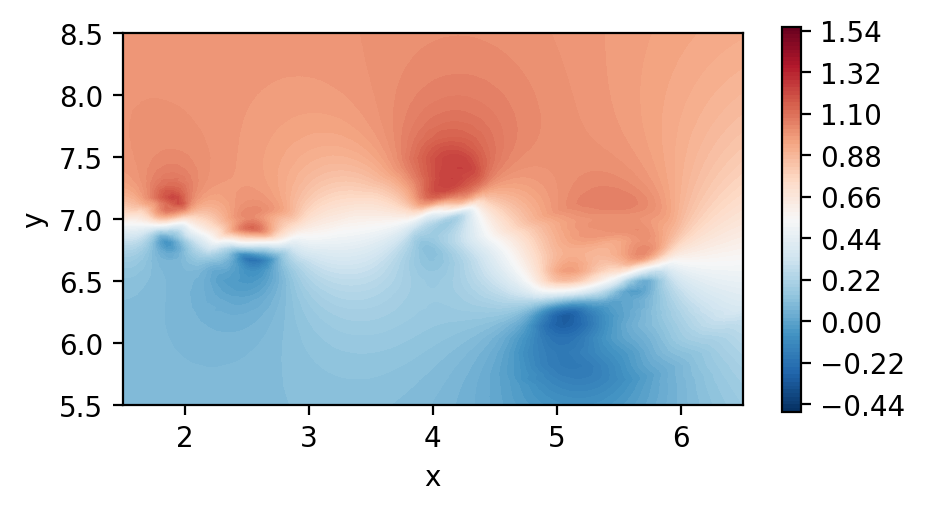

In [22]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,fld.registry["u"].flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

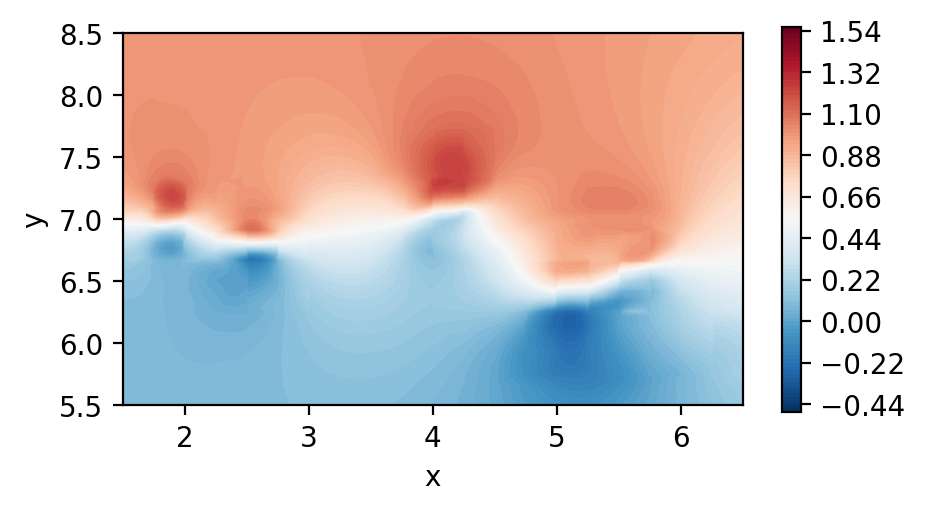

In [23]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
#c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() , fld.registry["u"].flatten() - recon.flatten(), levels=100, cmap="RdBu_r")
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,recon.flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

In [24]:
print(np.mean(fld.registry["u"] - recon))
print(np.max(abs(fld.registry["u"] - recon)))
print(np.min(abs(fld.registry["u"] - recon)))

-2.307496793984864e-06
0.5459433391677186
0.0
